# Abstract

Get to know the data, try to query one image, get a result and visualize it together with the features.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from cirtorch.datasets.testdataset import configdataset
from cirtorch.utils.evaluate import compute_map_and_print
from asmk import io_helpers, ASMKMethod
from examples.demo_how import build_ivf, query_ivf

In [2]:
PARAMETERS_PATH = 'eccv20_how_r50-_1000'
DATASET = 'roxford5k'
EVAL_FEATURES = 'how_r50-_1000'

In [3]:
# Global variables
package_root = Path('.').resolve().parent / 'asmk'
parameters_path = package_root / "examples" / ("params/%s.yml" % PARAMETERS_PATH)
params = io_helpers.load_params(parameters_path)

globals = {}
globals["root_path"] = (package_root / params['demo_how']['data_folder'])
exp_name = Path(parameters_path).name[:-len(".yml")]
globals["exp_path"] = (package_root / params['demo_how']['exp_folder']) / exp_name

In [4]:
# Setup logging
logger = io_helpers.init_logger(None)
logger.info("All variables and logger set up")

ASMK INFO: All variables and logger set up


In [5]:
# Run demo
asmk = ASMKMethod.initialize_untrained(params)
logger.info("Created uninitialized ASMK")
asmk = asmk.train_codebook(cache_path=f"{globals['exp_path']}/codebook.pkl")
logger.info("Trained ASMK")

desc = io_helpers.load_pickle(f"{globals['root_path']}/features/{DATASET}_{EVAL_FEATURES}.pkl")
gnd = configdataset(DATASET, f"{globals['root_path']}/test/")

asmk_dataset = build_ivf(asmk, DATASET, desc, globals, logger)

ASMK INFO: Created uninitialized ASMK
ASMK INFO: Trained ASMK
ASMK INFO: Loaded indexed ivf


In [6]:
# Run one query
first_query_index = np.searchsorted(desc['qimids'], desc['qimids'][0], side='right')
qvecs = desc['qvecs'][:first_query_index]
qimids = desc['qimids'][:first_query_index]

metadata, images, ranks, scores = asmk_dataset.query_ivf(qvecs, qimids)
print('query', gnd['qimlist'][images[0]])
print('top 1', gnd['imlist'][ranks[0, 0]])
print('score', scores[0, 0])
print()
print('Seems like working (y)')

query all_souls_000013
top 1 all_souls_000126
score 0.017260683622055892

Seems like working (y)


---

Take `qvecs` and get the visual word IDs so we can later on create tentative correspondences.

In [7]:
des, centroid_ids = asmk_dataset.codebook.quantize(qvecs, multiple_assignment=1)

In [8]:
des.shape, centroid_ids.shape, qvecs.shape

((1000, 128), (1000, 1), (1000, 128))

In [9]:
(des == qvecs).all()

True

In [10]:
unique_centroids, unique_centroids_counts = np.unique(centroid_ids, return_counts=True)

print(f'unique_centroids.shape={unique_centroids.shape}')
print(f'max counts: {sorted(unique_centroids_counts, reverse=True)[:10]}')

unique_centroids.shape=(486,)
max counts: [14, 14, 13, 11, 11, 11, 10, 10, 9, 9]


---

Now we have `qvecs` and we have `ranks[0, 0]` with the best match DB image ID. First, we need to create tentative correspondences based on visual words.

In [49]:
desc.keys()

dict_keys(['vecs', 'imids', 'scales', 'coordx', 'coordy', 'strengths', 'qvecs', 'qimids', 'qscales', 'qcoordx', 'qcoordy', 'qstrengths'])

In [50]:
dbid = ranks[0, 0]
qid = images[0]
db_img_mask = desc['imids'] == dbid
dbvecs = desc['vecs'][db_img_mask]

gnd['imlist'][dbid], dbvecs.shape

('all_souls_000126', (1000, 128))

In [51]:
_, q_centroid_ids = asmk_dataset.codebook.quantize(qvecs, multiple_assignment=1)
_, db_centroid_ids = asmk_dataset.codebook.quantize(dbvecs, multiple_assignment=1)

In [52]:
def get_tentative_correspondencies(q_ids, db_ids, max_tc=1500, max_MxN=15):
    # This is almost the same as the cython version. The only change is that now we are passing
    # only the query and database ids and the uniqueness and sorting is happening here.
    db_unique, db_counts = np.unique(db_ids, return_counts=True)
    q_unique, q_counts = np.unique(q_ids, return_counts=True)
    
    db_sorted = np.argsort(db_ids)
    q_sorted = np.argsort(q_ids)
    
    ret = []
    counts = []
    
    qr_i = 0  # query index
    db_i = 0  # database index
    s_qr_i = 0  # sorted query index
    s_db_i = 0  # sorted database index

    qr_len = q_unique.shape[0]
    db_len = db_unique.shape[0]
    s_qry_len = q_sorted.shape[0]
    s_rel_len = db_sorted.shape[0]
    
    while qr_i < qr_len and db_i < db_len:  # While there are any visual words remaining
        if q_unique[qr_i] == db_unique[db_i]:  # If we encountered the the same visual word
            count = q_counts[qr_i] * db_counts[db_i]
            if count <= max_MxN:
            
                # Move the sorted indexes forward so we find the beginning of current visual word
                while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] != q_unique[qr_i]:
                    s_qr_i += 1
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] != db_unique[db_i]:
                    s_db_i += 1
                
                # Cross products of corresponding visual words
                s_qr_i_start = s_qr_i
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] == db_unique[db_i]:
                    s_qr_i = s_qr_i_start
                    while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] == q_unique[qr_i]:
                        ret.append([q_sorted[s_qr_i], db_sorted[s_db_i]])
                        counts.append(count)
                        s_qr_i += 1
                    s_db_i += 1
                    
            qr_i += 1
            db_i += 1
        elif q_unique[qr_i] < db_unique[db_i]:
            qr_i += 1
        else:
            db_i += 1
            
    ret_np = np.array(ret, dtype=int, ndmin=2)
        
    # If there are way too many correspondences, crop the result
    if ret_np.shape[0] > max_tc:
        counts_np = np.array(counts)
        keys = np.argsort(counts, kind='stable')[:max_tc]
        return ret_np[keys]

    return ret_np


corrs = get_tentative_correspondencies(q_centroid_ids.ravel(), db_centroid_ids.ravel(), max_MxN=15)
corrs.shape

(453, 2)

In [62]:
np.sort(db_centroid_ids.ravel())

array([  125,   131,   145,   145,   145,   145,   145,   145,   145,
         145,   145,   204,   204,   204,   252,   252,   274,   274,
         274,   276,   276,   276,   276,   484,   484,   538,   538,
         628,   819,  1073,  1152,  1227,  1231,  1231,  1231,  1303,
        1472,  1508,  1697,  1734,  1734,  1734,  1911,  2184,  2282,
        2282,  2282,  2282,  2282,  2302,  2732,  2732,  2745,  2745,
        2789,  2818,  2818,  2818,  2818,  2818,  2853,  2853,  2912,
        2966,  2966,  2966,  3143,  3143,  3143,  3143,  3143,  3143,
        3143,  3143,  3143,  3527,  3618,  3664,  3926,  3926,  3926,
        3968,  3968,  4021,  4283,  4283,  4283,  4283,  4575,  4601,
        4620,  4825,  4921,  4979,  4979,  5013,  5065,  5236,  5393,
        5393,  5594,  5648,  5746,  5792,  5801,  6037,  6370,  6531,
        6531,  6570,  6570,  6570,  6570,  6591,  6610,  6844,  6959,
        6959,  7136,  7136,  7256,  7256,  7256,  7256,  7256,  7256,
        7256,  7256,

---

Visualization...

In [15]:
import matplotlib.colors as mcolors
from itertools import cycle

In [16]:
IMAGES_ROOT = Path('.').resolve().parent / 'oxbuild_images'

In [17]:
query_img_name = gnd['qimlist'][images[0]]
result_img_name = gnd['imlist'][dbid]

query_img = plt.imread(IMAGES_ROOT / f'{query_img_name}.jpg')
result_img = plt.imread(IMAGES_ROOT / f'{result_img_name}.jpg')

In [18]:
query_img.shape, result_img.shape

((1024, 768, 3), (1024, 768, 3))

In [19]:
# uz to vidim, pouzivas featury resnet50-, ktere nezmensuji faktorem 32 ale 16 (protoze posledni vrstva
# resnetu se preskakuje), takze 1024 * 2 (scale) / 16 = 128. Timto zpusobem tedy muzes prechazet mezi
# souradnicemi feature mapy a vstupnim obrazkem. 

def plot_corrs(qimg, dbimg, qbbx=None, qx=None, qy=None, qs=None, dbx=None, dby=None, dbs=None):
    qh, qw, _ = qimg.shape
    dbh, dbw, _ = dbimg.shape
    
    img = np.zeros([max(qh, dbh), qw + dbw, 3], dtype=int)
    img[:qh, :qw] = qimg
    img[:dbh, qw:] = dbimg
    
    scales = [2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25]
    bbx, bby, *_ = qbbx if qbbx is not None else [0, 0]
    
    if all(i is not None for i in [qx, qy, qs, dbx, dby, dbs]):
        for x1, y1, s1, x2, y2, s2, c in zip(qx, qy, qs, dbx, dby, dbs, cycle(mcolors.TABLEAU_COLORS.values())):
            plt.plot(
                [int((x1 * 16 / scales[s1]) + bbx), int(x2 * 16 / scales[s2]) + qw],
                [int((y1 * 16 / scales[s1]) + bby), int(y2 * 16 / scales[s2])],
                color=c,
                marker='o',
                linestyle='dashed',
                linewidth=1,
                markersize=3,
            )
    
    plt.imshow(img)
    plt.show()

In [20]:
qbbx = gnd['gnd'][qid]['bbx']
qcoordx = desc['qcoordx'][:first_query_index]
qcoordy = desc['qcoordy'][:first_query_index]
qscales = desc['qscales'][:first_query_index]

dbcoordx = desc['coordx'][db_img_mask]
dbcoordy = desc['coordy'][db_img_mask]
dbscales = desc['scales'][db_img_mask]

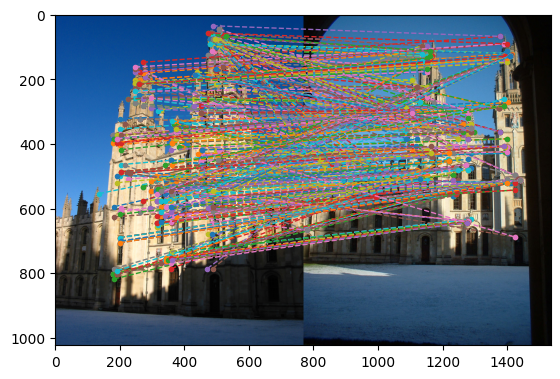

In [21]:
plot_corrs(
    query_img,
    result_img,
    qbbx=qbbx,
    qx=qcoordx[corrs[:, 0]],
    qy=qcoordy[corrs[:, 0]],
    qs=qscales[corrs[:, 0]],
    dbx=dbcoordx[corrs[:, 1]],
    dby=dbcoordy[corrs[:, 1]],
    dbs=dbscales[corrs[:, 1]],
)

---

Visualize a single image with its features.

In [22]:
desc.keys()

dict_keys(['vecs', 'imids', 'scales', 'coordx', 'coordy', 'strengths', 'qvecs', 'qimids', 'qscales', 'qcoordx', 'qcoordy', 'qstrengths'])

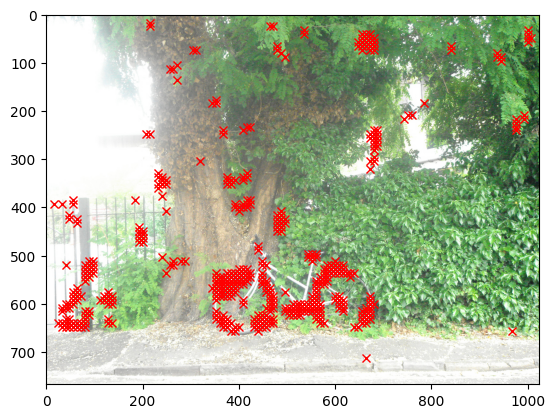

In [23]:
IMID = 6
m = (desc['scales'] == 0) & (desc['imids'] == IMID)

x = desc['coordx'][m]
y = desc['coordy'][m]

img = plt.imread(IMAGES_ROOT / f'{gnd["imlist"][IMID]}.jpg')
plt.imshow(img)
plt.plot(
    (x * 16 / 2).astype(int),
    (y * 16 / 2).astype(int),
    'rx',
)
plt.show()

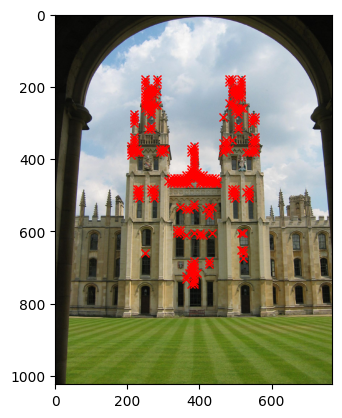

In [24]:
IMID = 2
x1, y1, x2, y2 = gnd['gnd'][IMID]['bbx']
m = (desc['qscales'] == 0) & (desc['qimids'] == IMID)

x = desc['qcoordx'][m]
y = desc['qcoordy'][m]

img = plt.imread(IMAGES_ROOT / f'{gnd["qimlist"][IMID]}.jpg')
plt.imshow(img)
plt.plot(
    (x * 16 / 2).astype(int) + x1,
    (y * 16 / 2).astype(int) + y1,
    'rx',
)
plt.show()

---

Now we have `coordx`, `coordy` and `scales` together with `corrs`. Generate hypotheses and possibly test them too.

In [25]:
print(qcoordx.shape, qcoordy.shape, qscales.shape)
print(dbcoordx.shape, dbcoordy.shape, dbscales.shape)
print(corrs.shape, corrs.max(axis=0))

(1000,) (1000,) (1000,)
(1000,) (1000,) (1000,)
(453, 2) [996 998]


In [26]:
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])

scales1 = scales[qscales[corrs[:, 0]]]
coordx1 = qcoordx[corrs[:, 0]] * 16 / scales1
coordy1 = qcoordy[corrs[:, 0]] * 16 / scales1

scales2 = scales[dbscales[corrs[:, 1]]]
coordx2 = dbcoordx[corrs[:, 1]] * 16 / scales2
coordy2 = dbcoordy[corrs[:, 1]] * 16 / scales2

$$
\begin{split}
\mathbf{M} & = \mathbf{T}_B \mathbf{S}_B \mathbf{S}_{-A} \mathbf{T}_{-A} \\
& = \begin{bmatrix}
1 & 0 & x_B \\
0 & 1 & y_B \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
s_B & 0 & 0 \\
0 & s_B & 0 \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\frac{1}{s_A} & 0 & 0 \\
0 & \frac{1}{s_A} & 0 \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
1 & 0 & -x_A \\
0 & 1 & -y_A \\
0 & 0 & 1
\end{bmatrix} \\
& =
\begin{bmatrix}
\frac{s_B}{s_A} & 0 & -x_A \frac{s_B}{s_A} + x_B \\
0 & \frac{s_B}{s_A} & -y_A \frac{s_B}{s_A} + y_B \\
0 & 0 & 1
\end{bmatrix}
\end{split}
$$

In [27]:
def generate_hypotheses(coordx1, coordy1, scales1, coordx2, coordy2, scales2):
    # 1 -> 2
    m = np.tile(np.eye(3), [coordx1.size, 1, 1])
    s = scales2 / scales1
    
    m[:, 0, 2] = -1 * coordx1 * s + coordx2
    m[:, 1, 2] = -1 * coordy1 * s + coordy2
    m[:, 0, 0] = m[:, 1, 1] = s
    
    return m

x1, y1, s1 = 10, 20, 0.5
x2, y2, s2 = 30, 25, 2.0
m = generate_hypotheses(
    np.array(x1),
    np.array(y1),
    np.array(s1),
    np.array(x2),
    np.array(y2),
    np.array(s2),
)

_x2, _y2, _ = (m[0] @ np.array([10, 20, 1])[:, np.newaxis]).ravel()
assert x2 == _x2
assert y2 == _y2

m

array([[[  4.,   0., -10.],
        [  0.,   4., -55.],
        [  0.,   0.,   1.]]])

In [28]:
hypotheses = generate_hypotheses(
    coordx1,
    coordy1,
    scales1,
    coordx2,
    coordy2,
    scales2,
)
hypotheses.shape

(453, 3, 3)

In [29]:
def compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2):
    pts1 = np.vstack([coordx1, coordy1, np.ones_like(coordx1)])
    pts2 = np.vstack([coordx2, coordy2, np.ones_like(coordx2)])
    
    # [number of hypotheses, number of correspondences]
    return np.linalg.norm((hypotheses @ pts1) - pts2, axis=1)

errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)

assert (errors[np.arange(errors.shape[0]), np.arange(errors.shape[0])] < 0.0001).all()

print(errors.shape)
errors[:4, :4]

(453, 453)


array([[  0.        ,  30.97995931, 319.43481916, 312.70045422],
       [133.11060406,   0.        , 416.12566995, 404.89381843],
       [477.11074569, 416.12566995,   0.        ,  32.00966692],
       [458.15399877, 404.89381843,  32.00966692,   0.        ]])

In [30]:
def compute_supports(errors, threshold=32):
    # Possibly add another argument, `corrs`, because in the more complex
    # case this will be how we want to compute it.
    return (errors <= threshold).sum(axis=1)


supports = compute_supports(errors)

assert (supports >= 1).all()

# -np.sort(-supports)[:10]
supports[:10]

array([31,  3, 14,  7, 10,  5,  4,  8,  6,  6])

In [31]:
supports.argmax(), supports[13]

(13, 76)

Num of inliers: 76


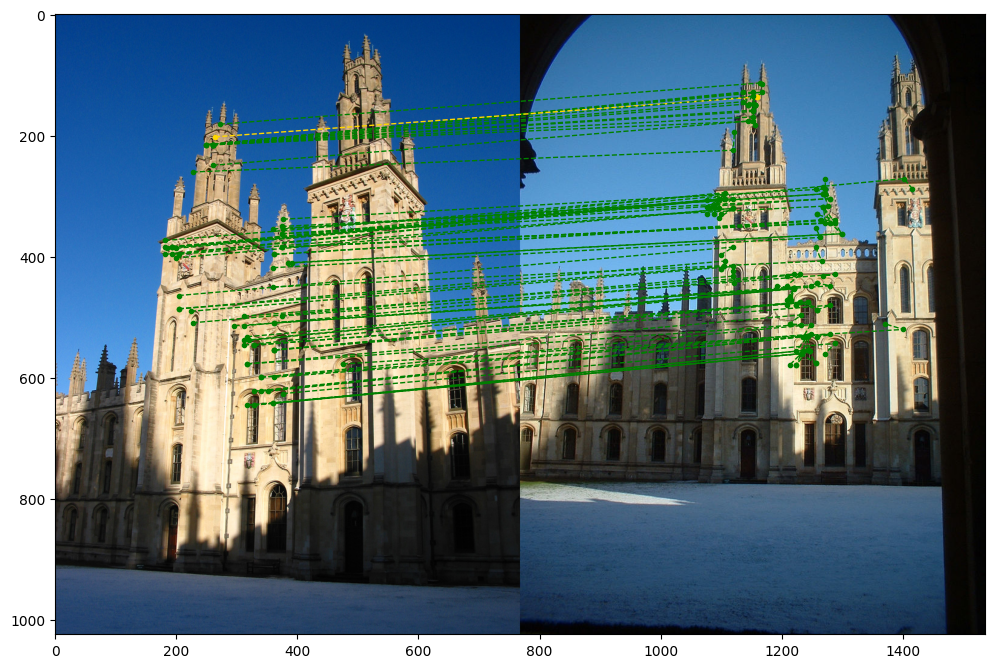

In [32]:
def plot_corrs(
    qimg, dbimg, qbbx=None, qx=None, qy=None, dbx=None, dby=None, inl=None, origin=None,
    tx=None, ty=None, skip_outliers=False,
):
    plt.figure(figsize=(12, 12))
    qh, qw, _ = qimg.shape
    dbh, dbw, _ = dbimg.shape
    
    img = np.zeros([max(qh, dbh), qw + dbw, 3], dtype=int)
    img[:qh, :qw] = qimg
    img[:dbh, qw:] = dbimg
    
    scales = [2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25]
    bbx, bby, *_ = qbbx if qbbx is not None else [0, 0]
    
    print('Num of inliers:', inl.sum())
    if all(i is not None for i in [qx, qy, dbx, dby, inl, tx, ty]):
        for i, (x1, y1, x2, y2, c, inlier, transx, transy) in enumerate(zip(
            qx, qy, dbx, dby, cycle(mcolors.TABLEAU_COLORS.values()), inl, tx, ty
        )):
            if origin == i:
                c = 'gold'
            else:
                c = 'green' if inlier else 'red'
            if c == 'red' and skip_outliers:
                continue
            plt.plot(
                [int(x1 + bbx), int(x2 + qw), int(transx + qw)],
                [int(y1 + bby), int(y2), int(transy)],
                color=c,
                marker='o',
                linestyle='dashed',
                linewidth=1,
                markersize=3,
            )
    
    plt.imshow(img)
    plt.show()
    

origin = 13
threshold = 32

inl_mask = (errors <= threshold)

pts1 = np.vstack([coordx1, coordy1, np.ones_like(coordx1)])
pts2 = np.vstack([coordx2, coordy2, np.ones_like(coordx2)])
transformed_pts1 = (hypotheses[origin] @ pts1)[:-1, :]

plot_corrs(
    query_img,
    result_img,
    qbbx=qbbx,
    qx=coordx1,
    qy=coordy1,
    dbx=coordx2,
    dby=coordy2,
    inl=inl_mask[origin],
    origin=origin,
    tx=transformed_pts1[0],
    ty=transformed_pts1[1],
    skip_outliers=True,
)

---

More correspondences, inlier analysis.

In [33]:
corrs = get_tentative_correspondencies(q_centroid_ids.ravel(), db_centroid_ids.ravel(), max_MxN=12)

In [34]:
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])

scales1_original = qscales[corrs[:, 0]]
scales1 = scales[qscales[corrs[:, 0]]]
coordx1 = qcoordx[corrs[:, 0]] * 16 / scales1
coordy1 = qcoordy[corrs[:, 0]] * 16 / scales1

scales2_original = dbscales[corrs[:, 1]]
scales2 = scales[dbscales[corrs[:, 1]]]
coordx2 = dbcoordx[corrs[:, 1]] * 16 / scales2
coordy2 = dbcoordy[corrs[:, 1]] * 16 / scales2

In [35]:
hypotheses = generate_hypotheses(coordx1, coordy1, scales1, coordx2, coordy2, scales2)
errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)

In [36]:
supports = (errors < 32).sum(axis=1)
top_n_idx = (-supports).argsort()[:10]
top_n_errors = errors[top_n_idx]

supports[top_n_idx]

array([76, 76, 76, 75, 74, 74, 74, 72, 72, 69])

Original scales

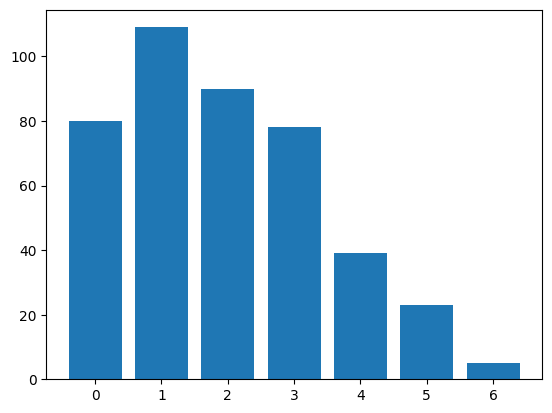

In [37]:
hist, bins = np.histogram(scales1_original, 7, (-0.5, 6.5))

plt.bar(np.arange(7), hist)
plt.show()

Top 1 hypothesis used scales

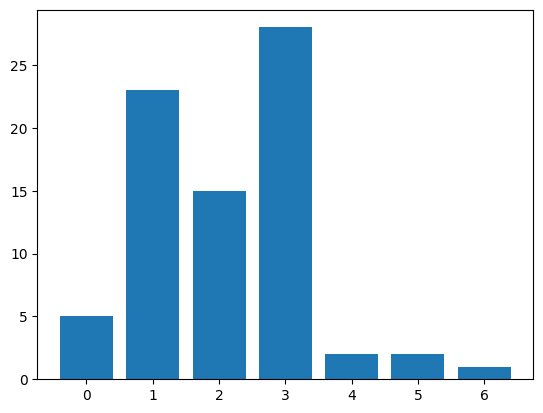

In [38]:
hist_top1, _ = np.histogram(scales1_original[top_n_errors[0] < 32], 7, (-0.5, 6.5))

plt.bar(np.arange(7), hist_top1)
plt.show()

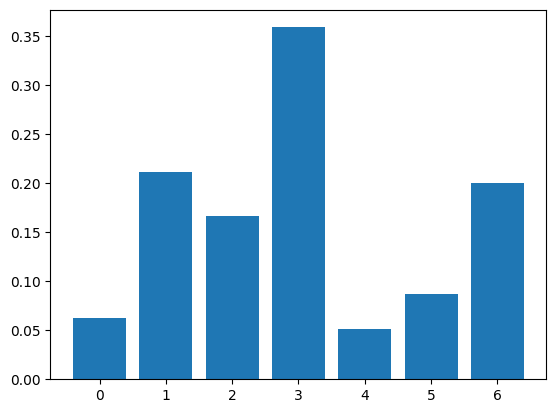

In [39]:
plt.bar(np.arange(7), hist_top1 / hist)
plt.show()

Top 10 used scales

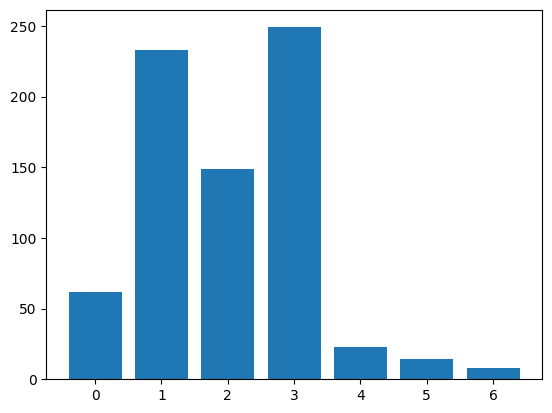

In [40]:
top_10_scales_original = np.tile(scales1_original, (10, 1))[(top_n_errors[:10] < 32)]
hist_top10, _ = np.histogram(top_10_scales_original, 7, (-0.5, 6.5))

plt.bar(np.arange(7), hist_top10)
plt.show()

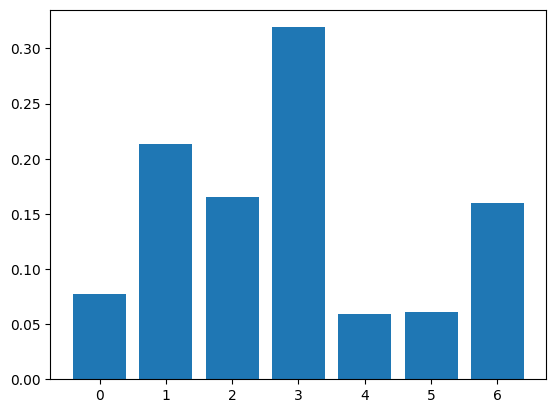

In [41]:
plt.bar(np.arange(7), hist_top10 / (hist * 10))
plt.show()

In [42]:
scales[3]

0.707

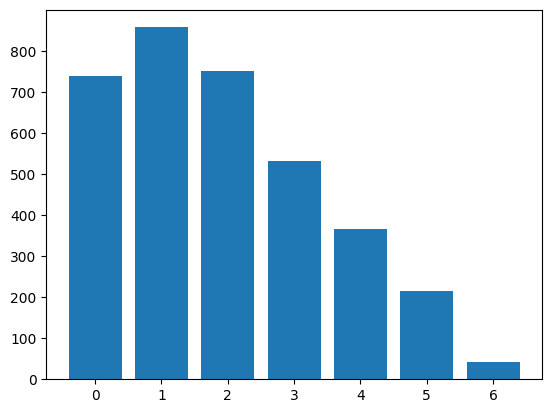

In [43]:
top_10_scales_original = np.tile(scales1_original, (10, 1))[~(top_n_errors[:10] < 32)]
hist_top10, _ = np.histogram(top_10_scales_original, 7, (-0.5, 6.5))

plt.bar(np.arange(7), hist_top10)
plt.show()

---

Some playground

In [44]:
desc.keys()

dict_keys(['vecs', 'imids', 'scales', 'coordx', 'coordy', 'strengths', 'qvecs', 'qimids', 'qscales', 'qcoordx', 'qcoordy', 'qstrengths'])

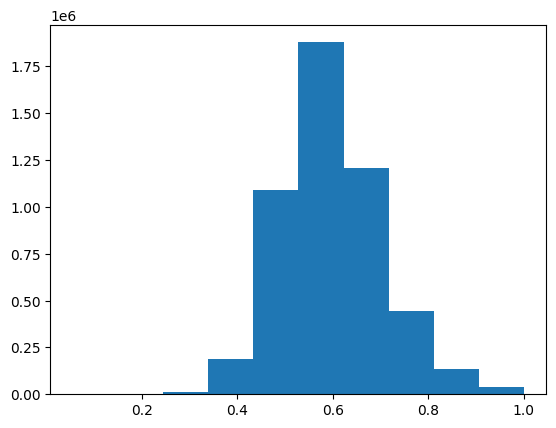

In [45]:
plt.hist(desc['strengths'])
plt.show()

---

Playground

In [46]:
desc.keys()

dict_keys(['vecs', 'imids', 'scales', 'coordx', 'coordy', 'strengths', 'qvecs', 'qimids', 'qscales', 'qcoordx', 'qcoordy', 'qstrengths'])

In [47]:
qvecs = desc['qvecs'][:first_query_index]
dbvecs = desc['vecs'][db_img_mask]

qvecs.shape, dbvecs.shape

((1000, 128), (1000, 128))

In [48]:
vecs1 = qvecs[corrs[:, 0]]
vecs2 = dbvecs[corrs[:, 1]]

vecs1.shape, vecs2.shape

((424, 128), (424, 128))